<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

***Some parts of the notebook are almost the copy of [ mmta-team course](https://github.com/mmta-team/mmta_fall_2020). Special thanks to mmta-team for making them publicly available. [Original notebook](https://github.com/mmta-team/mmta_fall_2020/blob/master/tasks/01_word_embeddings/task_word_embeddings.ipynb).***

<b> Прочитайте семинар, пожалуйста, для успешного выполнения домашнего задания. В конце ноутка напишите свой вывод. Работа без вывода оценивается ниже.

## Задача поиска схожих по смыслу предложений

Мы будем ранжировать вопросы [StackOverflow](https://stackoverflow.com) на основе семантического векторного представления

До этого в курсе не было речи про задачу ранжировния, поэтому введем математическую формулировку

## Задача ранжирования(Learning to Rank)

* $X$ - множество объектов
* $X^l = \{x_1, x_2, ..., x_l\}$ - обучающая выборка
<br>На обучающей выборке задан порядок между некоторыми элементами, то есть нам известно, что некий объект выборки более релевантный для нас, чем другой:
* $i \prec j$ - порядок пары индексов объектов на выборке $X^l$ c индексами $i$ и $j$
### Задача:
построить ранжирующую функцию $a$ : $X \rightarrow R$ такую, что
$$i \prec j \Rightarrow a(x_i) < a(x_j)$$

<img src="https://d25skit2l41vkl.cloudfront.net/wp-content/uploads/2016/12/Featured-Image.jpg" width=500, height=450>

### Embeddings

Будем использовать предобученные векторные представления слов на постах Stack Overflow.<br>
[A word2vec model trained on Stack Overflow posts](https://github.com/vefstathiou/SO_word2vec)

In [ ]:
!wget https://zenodo.org/record/1199620/files/SO_vectors_200.bin?download=1

--2025-03-03 08:07:12--  https://zenodo.org/record/1199620/files/SO_vectors_200.bin?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1199620/files/SO_vectors_200.bin [following]
--2025-03-03 08:07:12--  https://zenodo.org/records/1199620/files/SO_vectors_200.bin
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1453905423 (1.4G) [application/octet-stream]
Saving to: ‘SO_vectors_200.bin?download=1’

SO_vectors_200.bin? 100%[===================>]   1.35G  3.40MB/s    in 5m 15s  

2025-03-03 08:12:28 (4.40 MB/s) - ‘SO_vectors_200.bin?download=1’ saved [1453905423/1453905423]



In [ ]:
from gensim.models.keyedvectors import KeyedVectors
wv_embeddings = KeyedVectors.load_word2vec_format("SO_vectors_200.bin?download=1", binary=True)

#### Как пользоваться этими векторами?

Посмотрим на примере одного слова, что из себя представляет embedding

In [ ]:
word = 'dog'
if word in wv_embeddings:
    print(wv_embeddings[word].dtype, wv_embeddings[word].shape)

float32 (200,)


In [ ]:
# wv_embeddings[0]

In [ ]:
print(f"Num of words: {len(wv_embeddings.index_to_key)}")

Num of words: 1787145


Найдем наиболее близкие слова к слову `dog`:

#### ***Вопрос 1:***
* Входит ли слово `cat` в топ-5 близких слов к слову `dog`? Какое место оно занимает?


In [ ]:
# method most_simmilar
# нам дана модель, найдем

similar_words = wv_embeddings.most_similar("dog", topn=5)
print(similar_words)


[('animal', 0.8564180135726929), ('dogs', 0.7880866527557373), ('mammal', 0.7623804211616516), ('cats', 0.7621253728866577), ('animals', 0.760793924331665)]


***Ваш ответ:*** 'cat' не входит в топ-5 ближайших слов к 'dog'.

### Векторные представления текста

Перейдем от векторных представлений отдельных слов к векторным представлениям вопросов, как к **среднему** векторов всех слов в вопросе. Если для какого-то слова нет предобученного вектора, то его нужно пропустить. Если вопрос не содержит ни одного известного слова, то нужно вернуть нулевой вектор.

In [ ]:
import numpy as np
import re
# you can use your tokenizer
# for example, from nltk.tokenize import WordPunctTokenizer
# class MyTokenizer:
#     def __init__(self):
#         pass
#     def tokenize(self, text):
#         return re.findall('\w+', text)
# tokenizer = MyTokenizer()


class MyTokenizer:
    def __init__(self):
        pass

    def tokenize(self, text):
        return [word.lower() for word in re.findall(r'\w+', text)]  # Приводим к нижнему регистру

tokenizer = MyTokenizer()


In [ ]:
def question_to_vec(question, embeddings, tokenizer, dim=200):
    """
        question: строка
        embeddings: наше векторное представление
        dim: размер любого вектора в нашем представлении

        return: векторное представление для вопроса
    """
    tokens = tokenizer.tokenize(question)  # Разбиваем на слова
    word_vectors = [embeddings[word] for word in tokens if word in embeddings]  # Берем вектора, если есть

    if not word_vectors:  # Если нет известных слов, возвращаем нулевой вектор
        return np.zeros(dim)

    return np.mean(word_vectors, axis=0)

Теперь у нас есть метод для создания векторного представления любого предложения.

#### ***Вопрос 2:***

* Какая третья (с индексом 2) компонента вектора предложения `I love neural networks` (округлите до 2 знаков после запятой)?

In [ ]:
# Предложение
question = "I love neural networks"

# просто посмотреть
print(tokenizer.tokenize(question))
# решение
print(round(question_to_vec(question,wv_embeddings,tokenizer)[2],2))

['i', 'love', 'neural', 'networks']
-1.29


### Оценка близости текстов

Представим, что мы используем идеальные векторные представления слов. Тогда косинусное расстояние между дублирующими предложениями должно быть меньше, чем между случайно взятыми предложениями.

Сгенерируем для каждого из $N$ вопросов $R$ случайных отрицательных примеров и примешаем к ним также настоящие дубликаты. Для каждого вопроса будем ранжировать с помощью нашей модели $R + 1$ примеров и смотреть на позицию дубликата. Мы хотим, чтобы дубликат был первым в ранжированном списке.

#### Hits@K
Первой простой метрикой будет количество корректных попаданий для какого-то $K$:
$$ \text{Hits@K} = \frac{1}{N}\sum_{i=1}^N \, [rank\_q_i^{'} \le K],$$
* $\begin{equation*}
[x < 0 ] \equiv
 \begin{cases}
   1, &x < 0\\
   0, &x \geq 0
 \end{cases}
\end{equation*}$ - индикаторная функция
* $q_i$ - $i$-ый вопрос
* $q_i^{'}$ - его дубликат
* $rank\_q_i^{'}$ - позиция дубликата в ранжированном списке ближайших предложений для вопроса $q_i$.

Hits@K  измеряет долю вопросов, для которых правильный ответ попал в топ-K позиций среди отранжированных кандидатов.

#### DCG@K
Второй метрикой будет упрощенная DCG метрика, учитывающая порядок элементов в списке путем домножения релевантности элемента на вес равный обратному логарифму номера позиции::
$$ \text{DCG@K} = \frac{1}{N} \sum_{i=1}^N\frac{1}{\log_2(1+rank\_q_i^{'})}\cdot[rank\_q_i^{'} \le K],$$
С такой метрикой модель штрафуется за большой ранк корректного ответа.

DCG@K  измеряет качество ранжирования, учитывая не только факт наличия правильного ответа в топ-K, но и ***его точную позицию***.

<img src='https://hsto.org/files/1c5/edf/dee/1c5edfdeebce4b71a86bdf986d9f88f2.jpg' width=400, height=200>

#### Пример оценок

Вычислим описанные выше метрики для игрушечного примера.
Пусть
* $N = 1$, $R = 3$
* <font color='green'>"Что такое python?"</font> - вопрос $q_1$
* <font color='red'>"Что такое язык python?"</font> - его дубликат $q_i^{'}$

Пусть модель выдала следующий ранжированный список кандидатов:

1. "Как изучить с++?"
2. <font color='red'>"Что такое язык python?"</font>
3. "Хочу учить Java"
4. "Не понимаю Tensorflow"

$\Rightarrow rank\_q_i^{'} = 2$

Вычислим метрику *Hits@K* для *K = 1, 4*:

- [K = 1] $\text{Hits@1} =  [rank\_q_i^{'} \le 1]$

Проверяем условие $ \text{rank}_{q'_1} \leq 1 $: ***условие неверно***.

Следовательно, $[\text{rank}_{q'_1} \leq 1] = 0$.

- [K = 4] $\text{Hits@4} =  [rank\_q_i^{'} \le 4] = 1$

Проверяем условие $ \text{rank}_{q'_1} \leq 4 $: ***условие верно***.

Вычислим метрику *DCG@K* для *K = 1, 4*:
- [K = 1] $\text{DCG@1} = \frac{1}{\log_2(1+2)}\cdot[2 \le 1] = 0$
- [K = 4] $\text{DCG@4} = \frac{1}{\log_2(1+2)}\cdot[2 \le 4] = \frac{1}{\log_2{3}}$

#### ***Вопрос 3***:
* Вычислите `DCG@10`, если $rank\_q_i^{'} = 9$(округлите до одного знака после запятой)



In [ ]:
import math
K=10
N=1 # количество вопросов
rank_q=9
dcg10=1/(math.log2(1+rank_q))*(rank_q<=K)
print('DCG@10 =',round(dcg10,1))

DCG@10 = 0.3


#### Более сложный пример оценок

Рассмотрим пример с $ N > 1 $, где $ N = 3 $ (три вопроса) и для каждого вопроса заданы позиции их дубликатов. Вычислим метрики **Hits@K** для разных значений $ K $.

---

- $ N = 3 $: Три вопроса ($ q_1, q_2, q_3 $).
- Для каждого вопроса известна позиция его дубликата ($ \text{rank}_{q'_i} $):
  - $ \text{rank}_{q'_1} = 2 $,
  - $ \text{rank}_{q'_2} = 5 $,
  - $ \text{rank}_{q'_3} = 1 $.

Мы будем вычислять **Hits@K** для $ K = 1, 5 $.

---

**Для $ K = 1 $:**

Подставим значения:
$$
\text{Hits@1} = \frac{1}{3} \cdot \left( [\text{rank}_{q'_1} \leq 1] + [\text{rank}_{q'_2} \leq 1] + [\text{rank}_{q'_3} \leq 1] \right).
$$

Проверяем условие $ \text{rank}_{q'_i} \leq 1 $ для каждого вопроса:
- $ \text{rank}_{q'_1} = 2 $ → $ 2 \not\leq 1 $ → $ 0 $,
- $ \text{rank}_{q'_2} = 5 $ → $ 5 \not\leq 1 $ → $ 0 $,
- $ \text{rank}_{q'_3} = 1 $ → $ 1 \leq 1 $ → $ 1 $.

Сумма:
$$
\text{Hits@1} = \frac{1}{3} \cdot (0 + 0 + 1) = \frac{1}{3}.
$$

$$
\boxed{\text{Hits@1} = \frac{1}{3}}.
$$

---

**Для $ K = 5 $:**

Подставим значения:
$$
\text{Hits@5} = \frac{1}{3} \cdot \left( [\text{rank}_{q'_1} \leq 5] + [\text{rank}_{q'_2} \leq 5] + [\text{rank}_{q'_3} \leq 5] \right).
$$

Проверяем условие $ \text{rank}_{q'_i} \leq 5 $ для каждого вопроса:
- $ \text{rank}_{q'_1} = 2 $ → $ 2 \leq 5 $ → $ 1 $,
- $ \text{rank}_{q'_2} = 5 $ → $ 5 \leq 5 $ → $ 1 $,
- $ \text{rank}_{q'_3} = 1 $ → $ 1 \leq 5 $ → $ 1 $.

Сумма:
$$
\text{Hits@5} = \frac{1}{3} \cdot (1 + 1 + 1) = 1.
$$

$$
\boxed{\text{Hits@5} = 1}.
$$

Теперь вычислим метрику **DCG@K** для того же примера, где $ N = 3 $ (три вопроса), и для каждого вопроса известна позиция его дубликата ($ \text{rank}_{q'_i} $):

- $ \text{rank}_{q'_1} = 2 $,
- $ \text{rank}_{q'_2} = 5 $,
- $ \text{rank}_{q'_3} = 1 $.

Мы будем вычислять **DCG@K** для $ K = 1, 5 $.

---
**Для $ K = 1 $:**
Подставим значения:
$$
\text{DCG@1} = \frac{1}{3} \cdot \left( \frac{1}{\log_2(1 + \text{rank}_{q'_1})} \cdot [\text{rank}_{q'_1} \leq 1] + \frac{1}{\log_2(1 + \text{rank}_{q'_2})} \cdot [\text{rank}_{q'_2} \leq 1] + \frac{1}{\log_2(1 + \text{rank}_{q'_3})} \cdot [\text{rank}_{q'_3} \leq 1] \right).
$$

Проверяем условие $ \text{rank}_{q'_i} \leq 1 $ для каждого вопроса:
- $ \text{rank}_{q'_1} = 2 $ → $ 2 \not\leq 1 $ → $ 0 $,
- $ \text{rank}_{q'_2} = 5 $ → $ 5 \not\leq 1 $ → $ 0 $,
- $ \text{rank}_{q'_3} = 1 $ → $ 1 \leq 1 $ → $ 1 $.

Сумма:
$$
\text{DCG@1} = \frac{1}{3} \cdot (0 + 0 + 1) = \frac{1}{3}.
$$
$$
\boxed{\text{DCG@1} = \frac{1}{3}}.
$$

---


**Для $ K = 5 $:**
Подставим значения:
$$
\text{DCG@5} = \frac{1}{3} \cdot \left( \frac{1}{\log_2(1 + \text{rank}_{q'_1})} \cdot [\text{rank}_{q'_1} \leq 5] + \frac{1}{\log_2(1 + \text{rank}_{q'_2})} \cdot [\text{rank}_{q'_2} \leq 5] + \frac{1}{\log_2(1 + \text{rank}_{q'_3})} \cdot [\text{rank}_{q'_3} \leq 5] \right).
$$

Проверяем условие $ \text{rank}_{q'_i} \leq 5 $ для каждого вопроса:
- $ \text{rank}_{q'_1} = 2 $ → $ 2 \leq 5 $ → $ 1 $,
- $ \text{rank}_{q'_2} = 5 $ → $ 5 \leq 5 $ → $ 1 $,
- $ \text{rank}_{q'_3} = 1 $ → $ 1 \leq 5 $ → $ 1 $.

Сумма:
$$
\text{DCG@5} = \frac{1}{3} \cdot (0.631 + 0.387 + 1) = \frac{1}{3} \cdot 2.018 \approx 0.673.
$$

$$
\boxed{\text{DCG@5} \approx 0.673}.
$$

#### ***Вопрос 4:***
* Найдите максимум `Hits@47 - DCG@1`?



In [ ]:
# тк хитс - доля вопросов, для которых правильный ответ попал в топ-K позиций среди отранжированных кандидатов, то его максимум =1
# а дсж не может быть отрицательным -> макимум нашей итоговой функции = 1 (не судите строго, не поняла особо суть вопроса, но вроде двигалась в верном направлении.. или нет...)

### HITS\_COUNT и DCG\_SCORE

Каждая функция имеет два аргумента: $dup\_ranks$ и $k$.

$dup\_ranks$ является списком, который содержит рейтинги дубликатов (их позиции в ранжированном списке).

К примеру для <font color='red'>"Что такое язык python?"</font> $dup\_ranks = [2]$.

In [ ]:
def hits_count(dup_ranks, k):
    """
        dup_ranks: list индексов дубликатов
        k: пороговое значение для ранга
        result: вернуть Hits@k
    """
    # Подсчитываем количество дубликатов, чей ранг <= k
    hits_value = 0
    count=0
    for i in range (len(dup_ranks)):
        if dup_ranks[i]<=k:
          # каунт - просто подсчет числителя
          count+=1
        else:
          count+=0
        # итоговая функция:
        hits_value=1/(len(dup_ranks))*count
    return hits_value

In [ ]:
dup_ranks = [2]
k = 1
hits_value = hits_count(dup_ranks, k)
print(f"Hits@1 = {hits_value}")

k = 4
hits_value = hits_count(dup_ranks, k)
print(f"Hits@4 = {hits_value}")

Hits@1 = 0.0
Hits@4 = 1.0


In [ ]:
import math

def dcg_score(dup_ranks, k):
    """
        dup_ranks: list индексов дубликатов
        k: пороговое значение для ранга
        result: вернуть DCG@k
    """
    # Вычисляем сумму для всех релевантных дубликатов
    dcg_value = 0
    count=0
    for i in range (len(dup_ranks)):
        if dup_ranks[i]<=k:
          # каунт - просто подсчет числителя
          count+=1/(np.log2(1+dup_ranks[i]))
        else:
          count+=0
    # Делим на общее количество вопросов
    dcg_value=1/(len(dup_ranks))*count
    return dcg_value

In [ ]:
# Пример списка позиций дубликатов
dup_ranks = [2]

# Вычисляем DCG@1
dcg_value = dcg_score(dup_ranks, k=1)
print(f"DCG@1 = {dcg_value:.3f}")

# Вычисляем DCG@4
dcg_value = dcg_score(dup_ranks, k=4)
print(f"DCG@10 = {dcg_value:.3f}")

DCG@1 = 0.000
DCG@10 = 0.631


Протестируем функции. Пусть $N = 1$, то есть один эксперимент. Будем искать копию вопроса и оценивать метрики.

In [ ]:
import pandas as pd

In [ ]:
copy_answers = ["How does the catch keyword determine the type of exception that was thrown",]

# наши кандидаты
candidates_ranking = [["How Can I Make These Links Rotate in PHP",
                       "How does the catch keyword determine the type of exception that was thrown",
                       "NSLog array description not memory address",
                       "PECL_HTTP not recognised php ubuntu"],]

# dup_ranks — позиции наших копий, так как эксперимент один, то этот массив длины 1
dup_ranks = [2]

# вычисляем метрику для разных k
print('Ваш ответ HIT:', [hits_count(dup_ranks, k) for k in range(1, 5)])
print('Ваш ответ DCG:', [round(dcg_score(dup_ranks, k), 5) for k in range(1, 5)])

Ваш ответ HIT: [0.0, 1.0, 1.0, 1.0]
Ваш ответ DCG: [0.0, 0.63093, 0.63093, 0.63093]


У вас должно получиться

In [ ]:
# correct_answers - метрика для разных k
correct_answers = pd.DataFrame([[0, 1, 1, 1], [0, 1 / (np.log2(3)), 1 / (np.log2(3)), 1 / (np.log2(3))]],
                               index=['HITS', 'DCG'], columns=range(1,5))
correct_answers

,1,2,3,4
HITS,0,1.00000,1.00000,1.00000
DCG,0,0.63093,0.63093,0.63093


ура, все сошлось :)

### Данные
[arxiv link](https://drive.google.com/file/d/1QqT4D0EoqJTy7v9VrNCYD-m964XZFR7_/edit)

`train.tsv` - выборка для обучения.<br> В каждой строке через табуляцию записаны: **<вопрос>, <похожий вопрос>**

`validation.tsv` - тестовая выборка.<br> В каждой строке через табуляцию записаны: **<вопрос>, <похожий вопрос>, <отрицательный пример 1>, <отрицательный пример 2>, ...**

In [ ]:
!unzip stackoverflow_similar_questions.zip

unzip:  cannot find or open stackoverflow_similar_questions.zip, stackoverflow_similar_questions.zip.zip or stackoverflow_similar_questions.zip.ZIP.


Считайте данные.

In [ ]:
def read_corpus(filename):
    data = []
    with open(filename, encoding='utf-8') as file:
        for line in file:
            data.append(line.strip().split('\t'))
    return data

Нам понадобиться только файл validation.

In [ ]:
validation_data = read_corpus('/content/validation.tsv')

In [ ]:
validation_data[1]

['How to start PhoneStateListener programmatically?',
 'PhoneStateListener and service',
 'Java cast object[] to model',
 'WCF and What does this mean?',
 'How to uncheck checkbox using jQuery Uniform library',
 'Two projects with same code base',
 "Can't read php file when upload image to server in titanium",
 'create pandas dataframe from dictionary of dictionaries',
 'how to pass tkinter text to flex',
 'runtime error project source code not found and invalid string null exception?',
 'excel VBA new URL on existing IE',
 'Howto immediately update TextBox after correction of bound property?',
 'JAX-RS Jersey/Grizzly Define an interface resource',
 'JSONConvert.DeserializeObject not handling child array with unnamed array items',
 'Unexpected error while loading data',
 'Cucumber Capybara Selenium race condition with expect(all())',
 'How do I check if one vector is a subset of another?',
 'Dropdown list where options populate a second list js/php?',
 'Automated Email Sender',
 'mysql

Кол-во строк

In [ ]:
len(validation_data)

3760

Размер нескольких первых строк

In [ ]:
for i in range(25):
    print(i + 1, len(validation_data[i]))

1 1001
2 1001
3 1001
4 1001
5 1001
6 1001
7 1001
8 1001
9 1001
10 1001
11 1001
12 1001
13 1001
14 1001
15 1001
16 1001
17 1001
18 1001
19 1001
20 1001
21 1001
22 1001
23 1001
24 1001
25 1001


### Ранжирование без обучения

Реализуйте функцию ранжирования кандидатов на основе косинусного расстояния. Функция должна по списку кандидатов вернуть отсортированный список пар (позиция в исходном списке кандидатов, кандидат). При этом позиция кандидата в полученном списке является его рейтингом (первый - лучший). Например, если исходный список кандидатов был [a, b, c], и самый похожий на исходный вопрос среди них - c, затем a, и в конце b, то функция должна вернуть список **[(2, c), (0, a), (1, b)]**.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from copy import deepcopy

In [ ]:
def rank_candidates(question, candidates, embeddings, tokenizer, dim=200):
    """
        question: строка
        candidates: массив строк(кандидатов) [a, b, c]
        result: пары (начальная позиция, кандидат) [(2, c), (0, a), (1, b)]
    """
    question_v = question_to_vec(question, embeddings, tokenizer, dim)
    result=[]
    for i, j in enumerate(candidates):
      # i - его позиция в начальном списке (без сортировки), j - сам вопрос
      candidate_v=question_to_vec(j, embeddings, tokenizer, dim) # преобразуем кандидата в вектор
      distances=cosine_similarity([question_v], [candidate_v])    # посчитаем косинусное расстояние
      result.append((distances,i,j))    # прибавим его в наш список в виде (расстояние, исходный порядковый номер, сам кандидат )
    result.sort(reverse=True, key=lambda x: x[0])  # отсортируем в порядке убывания

    return [(idx, candidat) for raatoyanie,idx, candidat in result]




Протестируйте работу функции на примерах ниже. Пусть $N=2$, то есть два эксперимента

In [ ]:
questions = ['converting string to list', 'Sending array via Ajax fails']

candidates = [['Convert Google results object (pure js) to Python object', # первый эксперимент
               'C# create cookie from string and send it',
               'How to use jQuery AJAX for an outside domain?'],

              ['Getting all list items of an unordered list in PHP',      # второй эксперимент
               'WPF- How to update the changes in list item of a list',
               'select2 not displaying search results']]

In [ ]:
print(list(enumerate(candidates)))

[(0, ['Convert Google results object (pure js) to Python object', 'C# create cookie from string and send it', 'How to use jQuery AJAX for an outside domain?']), (1, ['Getting all list items of an unordered list in PHP', 'WPF- How to update the changes in list item of a list', 'select2 not displaying search results'])]


In [ ]:
for question, q_candidates in zip(questions, candidates):
        ranks = rank_candidates(question, q_candidates, wv_embeddings, tokenizer)
        print(ranks)
        print()

[(1, 'C# create cookie from string and send it'), (0, 'Convert Google results object (pure js) to Python object'), (2, 'How to use jQuery AJAX for an outside domain?')]

[(0, 'Getting all list items of an unordered list in PHP'), (2, 'select2 not displaying search results'), (1, 'WPF- How to update the changes in list item of a list')]



Для первого экперимента вы можете полностью сравнить ваши ответы и правильные ответы. Но для второго эксперимента два ответа на кандидаты будут <b>скрыты</b>(*)

In [ ]:
# должно вывести
results = [[(1, 'C# create cookie from string and send it'),
            (0, 'Convert Google results object (pure js) to Python object'),
            (2, 'How to use jQuery AJAX for an outside domain?')],
           [(*, 'Getting all list items of an unordered list in PHP'), #скрыт
            (*, 'select2 not displaying search results'), #скрыт
            (*, 'WPF- How to update the changes in list item of a list')]] #скрыт

Последовательность начальных индексов вы должны получить `для эксперимента 1`  1, 0, 2.

#### ***Вопрос 5:***
* Какую последовательность начальных индексов вы получили `для эксперимента 2`(перечисление без запятой и пробелов, например, `102` для первого эксперимента?


102 - для первого
021 - для второго

Теперь мы можем оценить качество нашего метода. Запустите следующие два блока кода для получения результата. Обратите внимание, что вычисление расстояния между векторами занимает некоторое время (примерно 10 минут). Можете взять для validation 1000 примеров.

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
wv_ranking = []
max_validation_examples = 100
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, wv_embeddings, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)

  0%|          | 0/3760 [00:00<?, ?it/s]

тут ноут немного умер

In [ ]:
for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.390 | Hits@   1: 0.390
DCG@   5: 0.490 | Hits@   5: 0.590
DCG@  10: 0.522 | Hits@  10: 0.690
DCG@ 100: 0.567 | Hits@ 100: 0.910
DCG@ 500: 0.577 | Hits@ 500: 0.980
DCG@1000: 0.579 | Hits@1000: 1.000


Из формул выше можно понять, что

- $ \text{Hits@K} $ **монотонно неубывающая функция** $ K $, которая стремится к 1 при $ K \to \infty $.

- $ \text{DCG@K} $ **монотонно неубывающая функция** $ K $, но рост замедляется с увеличением $ K $ из-за убывания веса $ \frac{1}{\log_2(1 + \text{rank}_{q'_i})} $.

### Эмбеддинги, обученные на корпусе похожих вопросов

In [ ]:
train_data = read_corpus('/content/train.tsv')

Улучшите качество модели.<br>Склеим вопросы в пары и обучим на них модель Word2Vec из gensim. Выберите размер window. Объясните свой выбор.

***Рассмотрим подробнее*** данное склеивание.

1. Каждая строка из train_data разбивается на вопрос (question) и список кандидатов.

2. Для каждого кандидата вопрос склеивается с ним в одну строку.

3. Склеенная строка (combined_text) токенизируется, и полученный список токенов добавляется в общий корпус (corpus).

***Пример***

    Вопрос: "What is Python?"
    Кандидаты: ["Python is a programming language", "Java is another language"]
    Склеенные строки:
        "What is Python? Python is a programming language"
        "What is Python? Java is another language"
         
    Токенизированные списки:
        ['what', 'is', 'python', 'python', 'is', 'a', 'programming', 'language']
        ['what', 'is', 'python', 'java', 'is', 'another', 'language']
         
     

In [ ]:
train_data[111258]

['Determine if the device is a smartphone or tablet?',
 'Change imageView params in all cards together']

In [ ]:
train_data[1]

['Which HTML 5 Canvas Javascript to use for making an interactive drawing tool?',
 'Event handling for geometries in Three.js?']

In [ ]:
train_data[1][1]

'Event handling for geometries in Three.js?'

In [ ]:
from array import array
# Создаем общий корпус текстов
corpus = []

def new_corpus(train_data,tokenizer):
  for item in train_data:
    for j in range(len(item)):
      if j!=0:
        text=[item[0], item[j]]
        combined_text=" ".join(text)
        tokens = tokenizer.tokenize(combined_text)
        corpus.append(tokens)
  return corpus

corpus=new_corpus(train_data,tokenizer)

In [ ]:
corpus[0]

['converting',
 'string',
 'to',
 'list',
 'convert',
 'google',
 'results',
 'object',
 'pure',
 'js',
 'to',
 'python',
 'object']

беру окно в 3 слова, тк предложения не слишком большие, ставить окно в 5 слов не имеет смысла

In [ ]:
from gensim.models import Word2Vec
embeddings_trained = Word2Vec(
    sentences=corpus,        # Корпус токенизированных текстов
    vector_size=200,         # Размерность векторов
    window=3,                # Размер окна контекста
    min_count=3,             # Минимальная частота слов
    workers=4                # Количество потоков
).wv

In [ ]:
wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, embeddings_trained, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)

  0%|          | 0/3760 [00:00<?, ?it/s]

In [ ]:
for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.305 | Hits@   1: 0.305
DCG@   5: 0.375 | Hits@   5: 0.441
DCG@  10: 0.394 | Hits@  10: 0.500
DCG@ 100: 0.449 | Hits@ 100: 0.768
DCG@ 500: 0.472 | Hits@ 500: 0.943
DCG@1000: 0.478 | Hits@1000: 1.000


##  **Попробуем улучшить скор**

###  ***Попытка 1 - покрутим настройки***

In [ ]:
embeddings_trained = Word2Vec(
    sentences=corpus,        # Корпус токенизированных текстов
    vector_size=200,         # Размерность векторов
    window=5,                # Размер окна контекста
    min_count=2,             # Минимальная частота слов
    workers=5               # Количество потоков
).wv

In [ ]:
wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, embeddings_trained, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)

  0%|          | 0/1958 [00:00<?, ?it/s]

In [ ]:
for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.315 | Hits@   1: 0.315
DCG@   5: 0.392 | Hits@   5: 0.461
DCG@  10: 0.415 | Hits@  10: 0.534
DCG@ 100: 0.468 | Hits@ 100: 0.792
DCG@ 500: 0.488 | Hits@ 500: 0.945
DCG@1000: 0.494 | Hits@1000: 1.000


###  ***Попытка 2 WordPunctTokenizer*** - попробуем другой токенайзер

In [ ]:
from nltk.tokenize import WordPunctTokenizer

tokenizer=WordPunctTokenizer()

corpus=new_corpus(train_data,tokenizer)

In [ ]:
corpus[0]

['converting',
 'string',
 'to',
 'list',
 'convert',
 'google',
 'results',
 'object',
 'pure',
 'js',
 'to',
 'python',
 'object']

In [ ]:
embeddings_trained = Word2Vec(
    sentences=corpus,        # Корпус токенизированных текстов
    vector_size=200,         # Размерность векторов
    window=5,                # Размер окна контекста
    min_count=2,             # Минимальная частота слов
    workers=5               # Количество потоков
).wv

In [ ]:
wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, embeddings_trained, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)

for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

  0%|          | 0/1958 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.270 | Hits@   1: 0.270
DCG@   5: 0.335 | Hits@   5: 0.397
DCG@  10: 0.355 | Hits@  10: 0.459
DCG@ 100: 0.409 | Hits@ 100: 0.732
DCG@ 500: 0.435 | Hits@ 500: 0.930
DCG@1000: 0.442 | Hits@1000: 1.000


###  ***Попытка 3 - стеммер и WordPunctTokenizer***

Сначала разберемся, что такое стемминг, что такое лематизация. Если кратко, то **стемминг** - процесс удаления суффиксов из слова. Для понимания ниже я прикреплю картинку ([источник](https://databasecamp.de/en/data/stemming-lemmatization)).

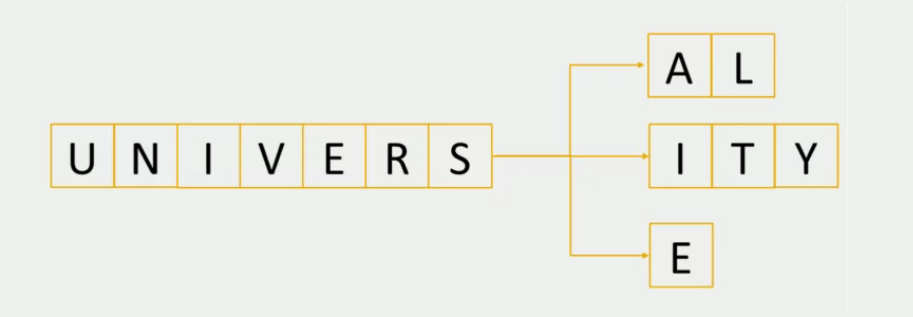

В то время как **лемматизация** помогает найти начальную форму слова.

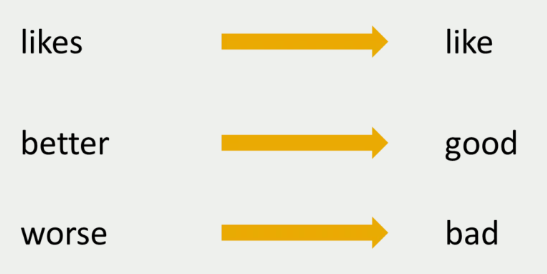

In [ ]:
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import PorterStemmer

ps = PorterStemmer()
tokenizer = WordPunctTokenizer()

corpus = []

def new_corpus(train_data, tokenizer):
    corpus = []
    for item in train_data:
        for j in range(len(item)):
            if j != 0:
                text = [item[0], item[j]]
                combined_text = " ".join(text)
                tokens = tokenizer.tokenize(combined_text)  # Токенизация
                stemmed_tokens = [ps.stem(word) for word in tokens]  # Применяем стеммер
                corpus.append(stemmed_tokens)  # Добавляем в корпус
    return corpus

corpus = new_corpus(train_data, tokenizer)
corpus

In [ ]:
embeddings_trained = Word2Vec(
    sentences=corpus,        # Корпус токенизированных текстов
    vector_size=200,         # Размерность векторов
    window=5,                # Размер окна контекста
    min_count=2,             # Минимальная частота слов
    workers=5               # Количество потоков
).wv

In [ ]:
wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, embeddings_trained, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)

for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

  0%|          | 0/3760 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.142 | Hits@   1: 0.142
DCG@   5: 0.184 | Hits@   5: 0.221
DCG@  10: 0.200 | Hits@  10: 0.271
DCG@ 100: 0.241 | Hits@ 100: 0.482
DCG@ 500: 0.276 | Hits@ 500: 0.764
DCG@1000: 0.301 | Hits@1000: 1.000


### ***Попытка 4 - личный токенайзер и стеммер***

In [ ]:
tokenizer = MyTokenizer()
ps = PorterStemmer()

corpus = []

def new_corpus(train_data, tokenizer):
    corpus = []
    for item in train_data:
        for j in range(len(item)):
            if j != 0:
                text = [item[0], item[j]]
                combined_text = " ".join(text)
                tokens = tokenizer.tokenize(combined_text)  # Токенизация
                stemmed_tokens = [ps.stem(word) for word in tokens]  # Применяем стеммер
                corpus.append(stemmed_tokens)  # Добавляем в корпус
    return corpus

corpus = new_corpus(train_data, tokenizer)
corpus[0]

['convert',
 'string',
 'to',
 'list',
 'convert',
 'googl',
 'result',
 'object',
 'pure',
 'js',
 'to',
 'python',
 'object']

In [ ]:
embeddings_trained = Word2Vec(
    sentences=corpus,        # Корпус токенизированных текстов
    vector_size=200,         # Размерность векторов
    window=5,                # Размер окна контекста
    min_count=2,             # Минимальная частота слов
    workers=5               # Количество потоков
).wv

In [ ]:
wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, embeddings_trained, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)

for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

  0%|          | 0/3760 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.221 | Hits@   1: 0.221
DCG@   5: 0.283 | Hits@   5: 0.341
DCG@  10: 0.303 | Hits@  10: 0.404
DCG@ 100: 0.353 | Hits@ 100: 0.650
DCG@ 500: 0.383 | Hits@ 500: 0.881
DCG@1000: 0.395 | Hits@1000: 1.000


### ***Попытка 5 - стеммер, убираем стоп-слова,свой токенайзер***

Стоп-словами в понимании нашей модели будут слова, которые:
1. часто встречаются
2. несут мало смысловой нагрузки

Примерами таких слов могут стать предлоги - но нужно помнить о том, что если убрать отрицательную частицу "не" - смысл предложения изменится.

In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
tokenizer = MyTokenizer()
ps = PorterStemmer()

corpus = []

def new_corpus(train_data, tokenizer):
    corpus = []
    for item in train_data:
        for j in range(len(item)):
            if j != 0:
                text = [item[0], item[j]]
                combined_text = " ".join(text)
                tokens = tokenizer.tokenize(combined_text)  # Токенизация
                tokens_filtered=[word for word in tokens if word not in stopWords]   # убираем стоп-слова
                stemmed_tokens = [ps.stem(word) for word in tokens_filtered]  # Применяем стеммер
                corpus.append(stemmed_tokens)  # Добавляем в корпус
    return corpus

corpus = new_corpus(train_data, tokenizer)
corpus[0]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['convert',
 'string',
 'list',
 'convert',
 'googl',
 'result',
 'object',
 'pure',
 'js',
 'python',
 'object']

In [ ]:
embeddings_trained = Word2Vec(
    sentences=corpus,        # Корпус токенизированных текстов
    vector_size=200,         # Размерность векторов
    window=5,                # Размер окна контекста
    min_count=6,             # Минимальная частота слов
    workers=5               # Количество потоков
).wv

In [ ]:
wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, embeddings_trained, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)

for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

  0%|          | 0/3760 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.290 | Hits@   1: 0.290
DCG@   5: 0.385 | Hits@   5: 0.469
DCG@  10: 0.407 | Hits@  10: 0.535
DCG@ 100: 0.449 | Hits@ 100: 0.745
DCG@ 500: 0.472 | Hits@ 500: 0.921
DCG@1000: 0.481 | Hits@1000: 1.000


--------------

## **Итоговый выбор:**

Оставляю модель со стеммингом, собственным токенайзером и убранными стоп-словами. для улучшения модели можно также попробовать использовать поиск имен собственных и другие эмбеддинги.